# Dynamic sense
The agent [learned general sense of environment](VAE.ipynb). Let us give the agent some memory, and now we want the agent to develop some sense of movement: being able to predict the following up sequence based on previous sequence memorized. Our agent follows a smooth trajectory, it should be able to figure it out.

In [1]:
import gym
import numpy as np
import numpy.random as rnd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sb
from gym_unity.envs import UnityEnv
from local import train_online, plot_history, run_seq
%matplotlib inline

Using TensorFlow backend.


In [2]:
env_name = None # use Unity editor with SimpleEnvironment scene active
#env_name = './Exec/Background' # use executable
env = UnityEnv(env_name, worker_id = 0, use_visual = True)

INFO:mlagents.envs:Start training by pressing the Play button in the Unity Editor.
INFO:mlagents.envs:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of Training Brains : 1
        Reset Parameters :
		
Unity brain name: SimpleEnvironment
        Number of Visual Observations (per agent): 1
        Vector Observation space size (per agent): 0
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): [2]
        Vector Action descriptions: Turn HORIZONTAL, Tilt VERTICAL
INFO:gym_unity:1 agents within environment.


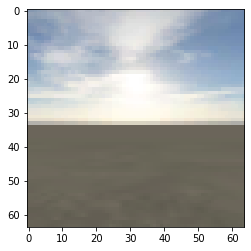

In [3]:
env.reset()
# get observation after taking action 0,0 (doing nothing)
observation, r, s, info = env.step([0.0, 0.0])

plt.imshow(observation)
plt.show()

In [4]:
IMG_DIM = observation.shape
ACT_DIM = (2,) # azimuth, altitude
N_CHANNELS = observation.shape[-1]
print('Image shape: {}  Flat size: {}  Channels: {}'\
      .format(IMG_DIM, np.prod(IMG_DIM), N_CHANNELS))

Image shape: (64, 64, 3)  Flat size: 12288  Channels: 3


## Conv + LSTM

In [5]:
from keras.models import Model
from keras.layers.convolutional import Conv3D
from keras.layers.convolutional_recurrent import ConvLSTM2D
from keras.layers import Input, Reshape
from keras.layers import BatchNormalization, Dropout
from keras.layers import Activation, LeakyReLU

In [6]:
# agent's brain capacity
MEMORY_LENGTH = 4

In [7]:
# agent's cortex structure
N_FILTERS = 32
N_LAYERS = 3

In [8]:
# take visual memory and output vision of the future
def predictor(img_dim, memory_length, name = 'predictor'):
    memory = Input(shape = [memory_length] + list(img_dim), name = 'memory')
    x = ConvLSTM2D(filters = N_FILTERS, kernel_size = (3, 3), padding = 'same', return_sequences = True)(memory)
    x = BatchNormalization()(x)
    for _ in range(N_LAYERS):
        x = ConvLSTM2D(filters = N_FILTERS, kernel_size = (3, 3), padding = 'same', return_sequences = True)(x)
        x = BatchNormalization()(x)
    expectation = Conv3D(filters = img_dim[-1], kernel_size = (3, 3, 3),
                         activation = 'sigmoid', padding = 'same',
                         name = 'expectation')(x)
    return Model(memory, expectation, name = 'predictor')

In [9]:
# instantiate encoder model
model = predictor(IMG_DIM, MEMORY_LENGTH)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
memory (InputLayer)          (None, 4, 64, 64, 3)      0         
_________________________________________________________________
conv_lst_m2d_1 (ConvLSTM2D)  (None, 4, 64, 64, 32)     40448     
_________________________________________________________________
batch_normalization_1 (Batch (None, 4, 64, 64, 32)     128       
_________________________________________________________________
conv_lst_m2d_2 (ConvLSTM2D)  (None, 4, 64, 64, 32)     73856     
_________________________________________________________________
batch_normalization_2 (Batch (None, 4, 64, 64, 32)     128       
_________________________________________________________________
conv_lst_m2d_3 (ConvLSTM2D)  (None, 4, 64, 64, 32)     73856     
_________________________________________________________________
batch_normalization_3 (Batch (None, 4, 64, 64, 32)     128       
__________

In [10]:
# compile data batch for online training (return inputs, targets)
def make_batch(V, A, X):
    assert V.shape[0] >= MEMORY_LENGTH * 2
    m = (V.shape[0] - MEMORY_LENGTH)//MEMORY_LENGTH//2
    M = m * MEMORY_LENGTH * 2 # actual batch-size
    shape = [m, MEMORY_LENGTH * 2] + list(IMG_DIM)
    return V[:M,:].reshape(shape)[:,:-MEMORY_LENGTH,:], V[:M,:].reshape(shape)[:,MEMORY_LENGTH:,:]

      1 Loss  trainig: 0.0632 validation: 0.0674
     10 Loss  trainig: 0.0142 validation: 0.0178
     20 Loss  trainig: 0.0129 validation: 0.0154
     30 Loss  trainig: 0.0103 validation: 0.0114
     40 Loss  trainig: 0.0085 validation: 0.0116
     50 Loss  trainig: 0.0083 validation: 0.0109
     60 Loss  trainig: 0.0070 validation: 0.0144
     70 Loss  trainig: 0.0075 validation: 0.0096
     80 Loss  trainig: 0.0077 validation: 0.0126
     90 Loss  trainig: 0.0071 validation: 0.0110
    100 Loss  trainig: 0.0069 validation: 0.0080


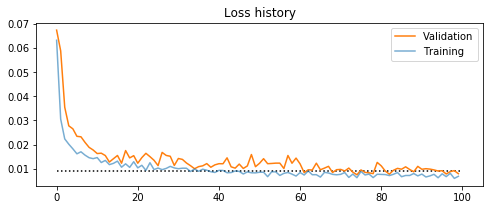

In [11]:
model.compile(loss = 'mean_squared_error', optimizer = 'adam')

batch_size = 16
batch_size = MEMORY_LENGTH * (2 * batch_size + 1)
log, V, A, X = train_online(env, model, make_batch, batch_size = batch_size, shuffle = False)
plot_history(log)

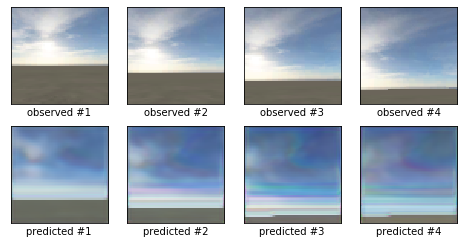

In [12]:
# show observed sequence vs. predicted
def seq_compare(observed, predicted):
    n = len(observed)
    fig, ax = plt.subplots(2, n, figsize = (8,4))
    for i in range(n):
        ax[0][i].imshow(observed[i])
        ax[0][i].set_xlabel('observed #{}'.format(i + 1))
        ax[0][i].set_xticks([])
        ax[0][i].set_yticks([])
        ax[1][i].imshow(predicted[i])
        ax[1][i].set_xlabel('predicted #{}'.format(i + 1))
        ax[1][i].set_xticks([])
        ax[1][i].set_yticks([])
    plt.show()

env.reset()
# generate simple sequence (same action)
actions = [np.array([8., -5.]) for i in range(MEMORY_LENGTH * 2)]
observed, coords = run_seq(env, actions)
# predict follow up sequence (second half based on first half)
prediction = model.predict(np.array(observed[:MEMORY_LENGTH]).reshape([1, MEMORY_LENGTH] + list(IMG_DIM)))
# compare predicted with actual
seq_compare(observed[:MEMORY_LENGTH], prediction.reshape([MEMORY_LENGTH] + list(IMG_DIM)))

In [13]:
env.close()